# Stage 2 - Lesson 4: Automated Backtesting with MLflow

In this notebook, we'll set up an automated backtesting pipeline for our stock price prediction model and track everything with MLflow.

**Learning Objectives:**
1. Set up a backtesting pipeline
2. Track backtesting results with MLflow
3. Evaluate trading strategies based on our predictions
4. Create visual performance reports

## 1. Import Libraries

In [1]:
# Core libraries
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# MLflow
import mlflow
import mlflow.xgboost
from mlflow.tracking import MlflowClient

# Set visual style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

# Set random seed for reproducibility
np.random.seed(42)

## 2. Set Up MLflow Tracking

In [2]:
# Configure MLflow
mlflow.set_tracking_uri("http://localhost:5000")

# Create a dedicated experiment for backtesting
experiment_name = "google_stock_backtesting"

# Create experiment if it doesn't exist
if mlflow.get_experiment_by_name(experiment_name) is None:
    experiment_id = mlflow.create_experiment(name=experiment_name)
    print(f"Created new experiment: {experiment_name} with ID: {experiment_id}")
else:
    experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
    print(f"Using existing experiment: {experiment_name} with ID: {experiment_id}")

# Set the active experiment
mlflow.set_experiment(experiment_name)

Using existing experiment: google_stock_backtesting with ID: 163887742140277747


<Experiment: artifact_location='mlflow-artifacts:/163887742140277747', creation_time=1739951108574, experiment_id='163887742140277747', last_update_time=1739951108574, lifecycle_stage='active', name='google_stock_backtesting', tags={}>

## 3. Load Data and Trained Model

In [3]:
# Load the historical and future data
def load_data():
    historical_data = pd.read_csv('../../data/mlops_stages/historical_features.csv')
    future_data = pd.read_csv('../../data/mlops_stages/future_features.csv')
    
    # Convert date columns
    historical_data['Date'] = pd.to_datetime(historical_data['Date'])
    future_data['Date'] = pd.to_datetime(future_data['Date'])
    
    return historical_data, future_data

historical_data, future_data = load_data()
print(f"Historical data: {historical_data.shape[0]} records from {historical_data['Date'].min()} to {historical_data['Date'].max()}")
print(f"Future data: {future_data.shape[0]} records from {future_data['Date'].min()} to {future_data['Date'].max()}")

Historical data: 802 records from 2021-06-16 00:00:00+00:00 to 2024-08-22 00:00:00+00:00
Future data: 90 records from 2024-08-23 00:00:00+00:00 to 2024-12-31 00:00:00+00:00


In [4]:
# Load our best model from previous experiment
def load_best_model():
    # Connect to the client
    client = MlflowClient()
    
    # Get our prediction experiment
    exp = client.get_experiment_by_name("google_stock_prediction")
    if not exp:
        raise Exception("Could not find the experiment 'google_stock_prediction'")
    
    # Search for the best run (lowest test RMSE)
    runs = client.search_runs(
        experiment_ids=[exp.experiment_id],
        filter_string="tags.model_type = 'xgboost'",
        order_by=["metrics.test_rmse ASC"],
        max_results=1
    )
    
    if not runs:
        raise Exception("No runs found with model_type='xgboost'")
        
    best_run = runs[0]
    print(f"Loading best model from run ID: {best_run.info.run_id}")
    print(f"Test RMSE: {best_run.data.metrics.get('test_rmse', 'Not recorded')}")
    
    # Load the model
    model_uri = f"runs:/{best_run.info.run_id}/xgboost_model"
    model = mlflow.xgboost.load_model(model_uri)
    
    return model, best_run.info.run_id

# Load the model
try:
    model, source_run_id = load_best_model()
    print("Successfully loaded the best model")
except Exception as e:
    print(f"Error loading model: {e}")
    
    # For the purpose of this notebook, we'll create a dummy model if loading fails
    import xgboost as xgb
    model = xgb.XGBRegressor(objective='reg:squarederror')
    X = historical_data.drop(['Date', 'target'], axis=1)
    y = historical_data['target']
    model.fit(X[:100], y[:100])  # Just a dummy model
    source_run_id = "dummy_model"

Loading best model from run ID: 243f356629e74bfebdd65d00961d2c65
Test RMSE: 22.57097075833727
Successfully loaded the best model


## 4. Create Backtesting Framework

Backtesting simulates how our trading strategy would have performed in the past. We'll:
1. Make predictions for each day
2. Create trading signals based on predicted price movements
3. Simulate trades and calculate returns
4. Evaluate strategy performance

In [5]:
def prepare_backtest_data(data):
    """Prepare data for backtesting"""
    # Sort by date
    data = data.sort_values('Date').reset_index(drop=True)
    
    # Extract features (everything except Date and target)
    feature_cols = [col for col in data.columns if col not in ['Date', 'target']]
    X = data[feature_cols]
    
    # Return prepared data
    return data, X, feature_cols

def generate_predictions(model, data, X):
    """Generate price predictions"""
    # Make predictions
    predictions = model.predict(X)
    
    # Create a new dataframe with date, actual price, and predicted price
    results = pd.DataFrame({
        'Date': data['Date'],
        'Actual': data['target'],
        'Predicted': predictions
    })
    
    # Calculate day-to-day price changes
    results['Actual_Change'] = results['Actual'].diff()
    results['Predicted_Change'] = results['Predicted'].diff()
    
    # Generate trading signals (1 for buy, -1 for sell, 0 for hold)
    results['Signal'] = np.where(results['Predicted_Change'] > 0, 1, 
                              np.where(results['Predicted_Change'] < 0, -1, 0))
    
    # Drop the first row (it has NaN for changes)
    results = results.dropna().reset_index(drop=True)
    
    return results

In [6]:
def simulate_trading(prediction_results, initial_capital=10000, fee_percent=0.1):
    """Simulate trading based on signals"""
    # Copy the results dataframe
    backtest = prediction_results.copy()
    
    # Calculate position (shares to hold)
    # If signal is 1, buy shares worth of our capital
    # If signal is -1, short-sell shares
    # If signal is 0, hold current position
    
    # Start with no position
    backtest['Position'] = 0
    
    # Calculate number of shares based on available capital and previous day's price
    first_day_price = backtest.iloc[0]['Actual']
    shares = initial_capital / first_day_price
    
    # Set up position based on signals
    backtest['Position'] = backtest['Signal'] * shares
    
    # Calculate holdings value each day
    backtest['Holdings'] = backtest['Position'] * backtest['Actual']
    
    # Calculate daily returns
    backtest['Returns'] = backtest['Position'] * backtest['Actual_Change']
    
    # Apply trading fees when position changes
    backtest['Position_Change'] = backtest['Position'].diff().fillna(backtest['Position'])
    backtest['Trading_Fee'] = abs(backtest['Position_Change'] * backtest['Actual']) * (fee_percent/100)
    backtest['Returns'] = backtest['Returns'] - backtest['Trading_Fee']
    
    # Calculate cumulative returns
    backtest['Cumulative_Returns'] = backtest['Returns'].cumsum() + initial_capital
    
    # Calculate Buy & Hold strategy for comparison
    buy_hold_shares = initial_capital / first_day_price
    backtest['Buy_Hold_Value'] = buy_hold_shares * backtest['Actual']
    
    return backtest

In [7]:
def calculate_performance_metrics(backtest_results, initial_capital=10000):
    """Calculate trading strategy performance metrics"""
    # Get the final values
    final_value = backtest_results['Cumulative_Returns'].iloc[-1]
    buy_hold_final = backtest_results['Buy_Hold_Value'].iloc[-1]
    
    # Calculate total return
    total_return = (final_value - initial_capital) / initial_capital * 100
    buy_hold_return = (buy_hold_final - initial_capital) / initial_capital * 100
    
    # Calculate daily returns
    daily_returns = backtest_results['Returns'] / initial_capital
    
    # Calculate annualized metrics (assuming 252 trading days per year)
    trading_days = len(backtest_results)
    years = trading_days / 252
    
    # Annualized return
    annualized_return = ((final_value / initial_capital) ** (1/years) - 1) * 100
    
    # Volatility (standard deviation of daily returns, annualized)
    volatility = daily_returns.std() * np.sqrt(252) * 100
    
    # Sharpe Ratio (assuming risk-free rate of 2%)
    risk_free_rate = 0.02
    sharpe_ratio = (annualized_return/100 - risk_free_rate) / (volatility/100)
    
    # Maximum Drawdown
    cumulative = backtest_results['Cumulative_Returns']
    max_drawdown = ((cumulative / cumulative.cummax()) - 1).min() * 100
    
    # Win rate (percentage of profitable trades)
    trades = backtest_results[backtest_results['Position_Change'] != 0]
    if len(trades) > 0:
        win_rate = (trades['Returns'] > 0).mean() * 100
    else:
        win_rate = 0
    
    # Number of trades
    num_trades = len(trades)
    
    # Create metrics dictionary
    metrics = {
        'total_return': total_return,
        'buy_hold_return': buy_hold_return,
        'annualized_return': annualized_return,
        'volatility': volatility,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate,
        'num_trades': num_trades,
        'trading_days': trading_days
    }
    
    return metrics

In [8]:
def plot_performance(backtest_results, metrics, title="Backtest Performance"):
    """Create performance visualization"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 1]})
    
    # Plot strategy vs buy & hold
    ax1.plot(backtest_results['Date'], backtest_results['Cumulative_Returns'], 
             label='Strategy', color='blue', linewidth=2)
    ax1.plot(backtest_results['Date'], backtest_results['Buy_Hold_Value'], 
             label='Buy & Hold', color='green', linestyle='--', linewidth=2)
    
    # Add labels and legend
    ax1.set_title(title, fontsize=16)
    ax1.set_ylabel('Portfolio Value ($)', fontsize=12)
    ax1.legend(fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Plot daily returns
    ax2.bar(backtest_results['Date'], backtest_results['Returns'], 
            color=np.where(backtest_results['Returns'] >= 0, 'green', 'red'),
            alpha=0.7)
    ax2.set_ylabel('Daily P&L ($)', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    # Add text box with metrics
    textstr = (
        f"Total Return: {metrics['total_return']:.2f}% (Buy & Hold: {metrics['buy_hold_return']:.2f}%)\n"
        f"Annualized Return: {metrics['annualized_return']:.2f}%\n"
        f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}\n"
        f"Max Drawdown: {metrics['max_drawdown']:.2f}%\n"
        f"Win Rate: {metrics['win_rate']:.2f}%\n"
        f"Trades: {metrics['num_trades']}\n"
        f"Period: {metrics['trading_days']} days"
    )
    props = dict(boxstyle='round', facecolor='white', alpha=0.7)
    ax1.text(0.02, 0.02, textstr, transform=ax1.transAxes, fontsize=10,
             verticalalignment='bottom', bbox=props)
    
    plt.tight_layout()
    return fig

## 5. Run Backtest and Track with MLflow

In [9]:
def run_backtest(data, model, initial_capital=10000, fee_percent=0.1, period_name="test"):
    """Run full backtest and log results to MLflow"""
    # Prepare data
    data_prepared, X, feature_cols = prepare_backtest_data(data)
    
    # Start MLflow run
    with mlflow.start_run(run_name=f"backtest_{period_name}") as run:
        # Log source model
        mlflow.log_param("source_model_run", source_run_id)
        mlflow.log_param("initial_capital", initial_capital)
        mlflow.log_param("trading_fee_percent", fee_percent)
        mlflow.log_param("period", period_name)
        mlflow.log_param("start_date", data_prepared['Date'].min())
        mlflow.log_param("end_date", data_prepared['Date'].max())
        mlflow.log_param("num_trading_days", len(data_prepared))
        
        # Set tags
        mlflow.set_tag("backtest_type", "signal_based")
        mlflow.set_tag("strategy", "trend_following")
        
        # Generate predictions
        prediction_results = generate_predictions(model, data_prepared, X)
        
        # Log prediction accuracy metrics
        direction_accuracy = np.mean(
            (prediction_results['Actual_Change'] > 0) == 
            (prediction_results['Predicted_Change'] > 0)
        )
        mlflow.log_metric("direction_accuracy", direction_accuracy)
        
        # Simulate trading
        backtest_results = simulate_trading(
            prediction_results, 
            initial_capital=initial_capital,
            fee_percent=fee_percent
        )
        
        # Calculate performance metrics
        metrics = calculate_performance_metrics(backtest_results, initial_capital)
        
        # Log all metrics
        for name, value in metrics.items():
            mlflow.log_metric(name, value)
            
        # Create performance chart
        fig = plot_performance(backtest_results, metrics, 
                              title=f"Backtest Performance: {period_name.capitalize()} Period")
        
        # Save and log figure
        fig_path = f"outputs/backtest_performance_{period_name}.png"
        plt.savefig(fig_path, dpi=300, bbox_inches='tight')
        mlflow.log_artifact(fig_path)
        plt.close(fig)
        
        # Save and log detailed results
        results_path = f"outputs/backtest_results_{period_name}.csv"
        backtest_results.to_csv(results_path, index=False)
        mlflow.log_artifact(results_path)
        
        # Log summary
        summary = (
            f"# Backtest Summary: {period_name.capitalize()} Period\n\n"
            f"## Overview\n"
            f"- Period: {data_prepared['Date'].min()} to {data_prepared['Date'].max()}\n"
            f"- Trading Days: {metrics['trading_days']}\n"
            f"- Initial Capital: ${initial_capital:,.2f}\n"
            f"- Trading Fee: {fee_percent}%\n\n"
            f"## Performance\n"
            f"- Strategy Return: {metrics['total_return']:.2f}%\n"
            f"- Buy & Hold Return: {metrics['buy_hold_return']:.2f}%\n"
            f"- Outperformance: {metrics['total_return'] - metrics['buy_hold_return']:.2f}%\n"
            f"- Annualized Return: {metrics['annualized_return']:.2f}%\n"
            f"- Volatility: {metrics['volatility']:.2f}%\n"
            f"- Sharpe Ratio: {metrics['sharpe_ratio']:.2f}\n"
            f"- Maximum Drawdown: {metrics['max_drawdown']:.2f}%\n\n"
            f"## Trading Statistics\n"
            f"- Total Trades: {metrics['num_trades']}\n"
            f"- Win Rate: {metrics['win_rate']:.2f}%\n"
            f"- Direction Prediction Accuracy: {direction_accuracy:.2f}%\n"
        )
        
        with open(f"outputs/backtest_summary_{period_name}.md", "w") as f:
            f.write(summary)
        mlflow.log_artifact(f"outputs/backtest_summary_{period_name}.md")
        
        print(f"Backtest complete. Results logged to run: {run.info.run_id}")
        return backtest_results, metrics, run.info.run_id

In [10]:
# Run backtest on historical data
historical_results, historical_metrics, historical_run_id = run_backtest(
    historical_data,
    model,
    initial_capital=10000,
    fee_percent=0.1,
    period_name="historical"
)

print(f"\nHistorical Backtest Performance:")
print(f"Total Return: {historical_metrics['total_return']:.2f}%")
print(f"Buy & Hold Return: {historical_metrics['buy_hold_return']:.2f}%")
print(f"Sharpe Ratio: {historical_metrics['sharpe_ratio']:.2f}")
print(f"Win Rate: {historical_metrics['win_rate']:.2f}%")

Backtest complete. Results logged to run: fb770fc89b304d808d12f5b5cc75b347
🏃 View run backtest_historical at: http://localhost:5000/#/experiments/163887742140277747/runs/fb770fc89b304d808d12f5b5cc75b347
🧪 View experiment at: http://localhost:5000/#/experiments/163887742140277747

Historical Backtest Performance:
Total Return: 420.80%
Buy & Hold Return: 34.55%
Sharpe Ratio: 2.13
Win Rate: 62.05%


In [11]:
# Run backtest on future (out-of-sample) data
future_results, future_metrics, future_run_id = run_backtest(
    future_data,
    model,
    initial_capital=10000,
    fee_percent=0.1,
    period_name="future"
)

print(f"\nFuture (Out-of-Sample) Backtest Performance:")
print(f"Total Return: {future_metrics['total_return']:.2f}%")
print(f"Buy & Hold Return: {future_metrics['buy_hold_return']:.2f}%")
print(f"Sharpe Ratio: {future_metrics['sharpe_ratio']:.2f}")
print(f"Win Rate: {future_metrics['win_rate']:.2f}%")

Backtest complete. Results logged to run: 071a9f63021141a1b2e98b264cf7cf71
🏃 View run backtest_future at: http://localhost:5000/#/experiments/163887742140277747/runs/071a9f63021141a1b2e98b264cf7cf71
🧪 View experiment at: http://localhost:5000/#/experiments/163887742140277747

Future (Out-of-Sample) Backtest Performance:
Total Return: -6.38%
Buy & Hold Return: 13.93%
Sharpe Ratio: -0.65
Win Rate: 42.86%


## 6. Compare Performance Between Time Periods

In [12]:
def compare_backtest_runs(run_ids, names):
    """Compare metrics from different backtest runs"""
    client = MlflowClient()
    
    # Metrics to compare
    key_metrics = [
        'total_return', 'buy_hold_return', 'annualized_return',
        'volatility', 'sharpe_ratio', 'max_drawdown', 'win_rate',
        'direction_accuracy', 'num_trades'
    ]
    
    # Create a dataframe to hold comparisons
    comparison = {}
    
    # Collect metrics for each run
    for run_id, name in zip(run_ids, names):
        run = client.get_run(run_id)
        metrics = run.data.metrics
        comparison[name] = {metric: metrics.get(metric, None) for metric in key_metrics}
        
    # Convert to DataFrame for easy display
    df = pd.DataFrame(comparison)
    
    return df

# Compare historical and future backtest results
comparison_df = compare_backtest_runs(
    [historical_run_id, future_run_id],
    ['Historical', 'Future (OOS)']
)

# Display comparison
comparison_df

,Historical,Future (OOS)
total_return,420.797286,-6.381393
buy_hold_return,34.545174,13.926335
annualized_return,68.061722,-17.031522
volatility,30.969752,29.303395
sharpe_ratio,2.133105,-0.649465
max_drawdown,-15.857718,-14.327915
win_rate,62.052506,42.857143
direction_accuracy,0.672909,0.460674
num_trades,419.000000,49.000000


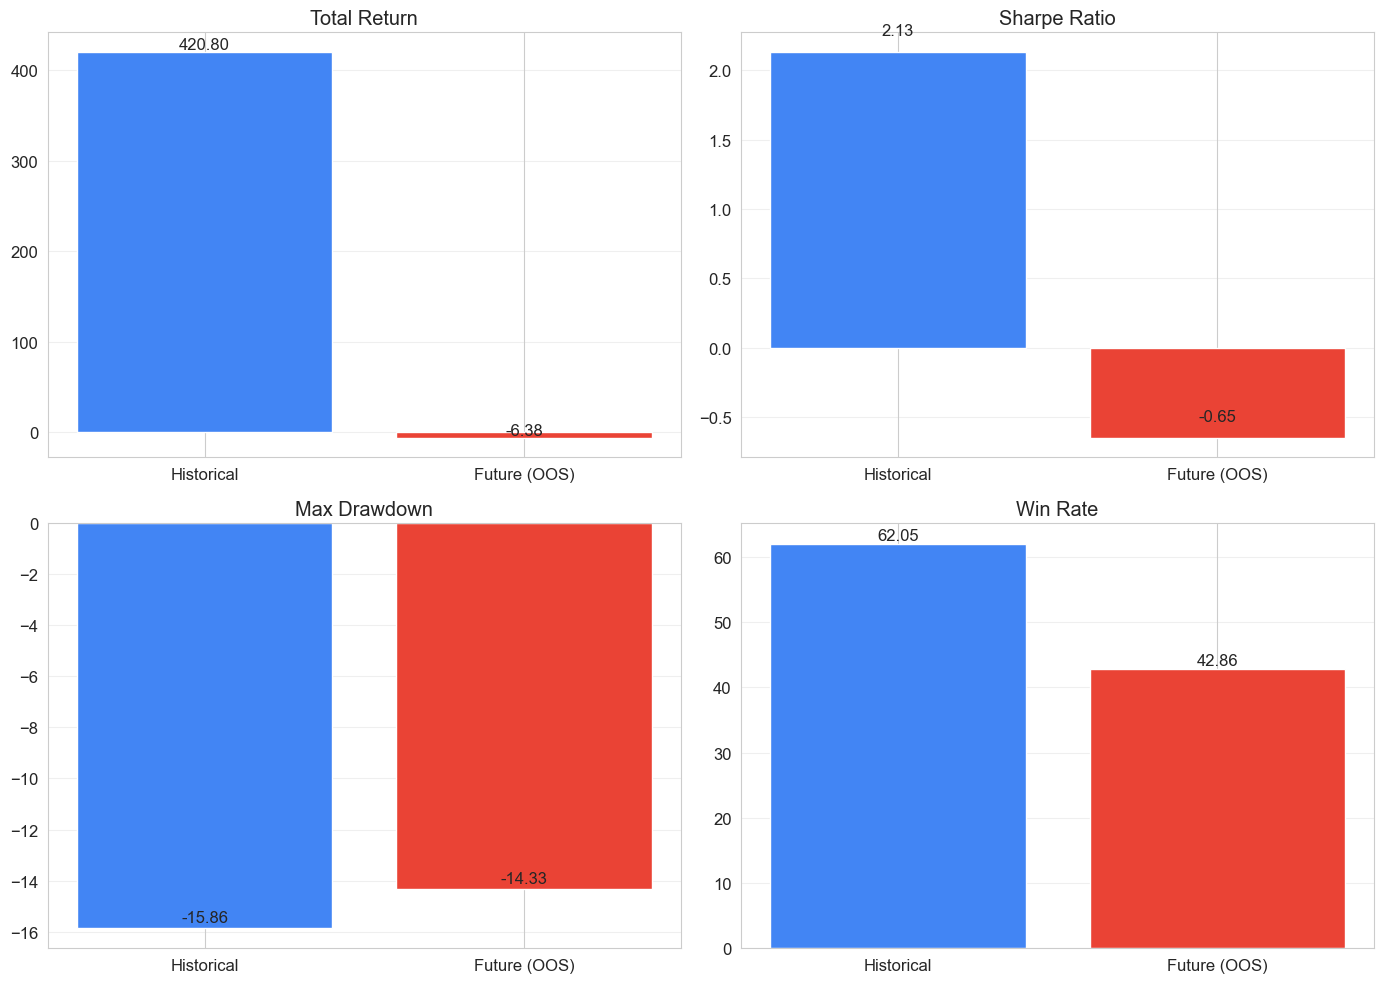

In [13]:
# Visualize key performance metrics comparison
def plot_metric_comparison(comparison_df):
    """Create bar charts comparing key metrics"""
    metrics_to_plot = [
        'total_return', 'sharpe_ratio', 'max_drawdown', 'win_rate'
    ]
    
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    axs = axs.flatten()
    
    for i, metric in enumerate(metrics_to_plot):
        # Get data and labels
        data = comparison_df.loc[metric]
        periods = data.index
        
        # Create bar chart
        bars = axs[i].bar(periods, data, color=['#4285F4', '#EA4335'])
        axs[i].set_title(f'{metric.replace("_", " ").title()}')
        axs[i].grid(axis='y', alpha=0.3)
        
        # Add data labels
        for bar in bars:
            height = bar.get_height()
            axs[i].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{height:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    return fig

# Create and display comparison chart
comparison_fig = plot_metric_comparison(comparison_df)
plt.tight_layout()
plt.show()

## 7. Create Automated Backtesting Pipeline

Now we'll create a reusable pipeline function that can be used for automated backtesting.

In [14]:
def automated_backtest_pipeline(model_uri, data_path, params=None):
    """Automated backtesting pipeline that can be scheduled"""
    # Default parameters
    default_params = {
        'initial_capital': 10000,
        'fee_percent': 0.1,
        'period_name': 'automated',
        'train_test_split': 0.8  # Use 80% for training, 20% for testing
    }
    
    # Update with custom parameters if provided
    if params:
        default_params.update(params)
    
    # Extract parameters
    initial_capital = default_params['initial_capital']
    fee_percent = default_params['fee_percent']
    period_name = default_params['period_name']
    train_test_split = default_params['train_test_split']
    
    print(f"Starting automated backtest with parameters: {default_params}")
    
    try:
        # Step 1: Load the model
        model = mlflow.xgboost.load_model(model_uri)
        print(f"Loaded model from: {model_uri}")
        
        # Step 2: Load and prepare data
        data = pd.read_csv(data_path)
        data['Date'] = pd.to_datetime(data['Date'])
        print(f"Loaded data from: {data_path} with {len(data)} records")
        
        # Step 3: Split data into train/test periods if needed
        data = data.sort_values('Date').reset_index(drop=True)
        split_idx = int(len(data) * train_test_split)
        
        train_data = data.iloc[:split_idx].copy()
        test_data = data.iloc[split_idx:].copy()
        
        # Step 4: Run backtest on test data
        results, metrics, run_id = run_backtest(
            test_data,
            model,
            initial_capital=initial_capital,
            fee_percent=fee_percent,
            period_name=period_name
        )
        
        # Step 5: Create summary for notification
        summary = {
            'run_id': run_id,
            'model_uri': model_uri,
            'test_period': f"{test_data['Date'].min()} to {test_data['Date'].max()}",
            'trading_days': len(test_data),
            'total_return': metrics['total_return'],
            'sharpe_ratio': metrics['sharpe_ratio'],
            'max_drawdown': metrics['max_drawdown'],
            'win_rate': metrics['win_rate']
        }
        
        print(f"Backtest completed successfully with run_id: {run_id}")
        return summary
        
    except Exception as e:
        print(f"Error in automated backtest: {str(e)}")
        return None

In [15]:
# Test the automated pipeline with a specific model URI
# (Use the URI from a previously trained model)
model_uri = f"runs:/{source_run_id}/xgboost_model" 
data_path = '../../data/mlops_stages/future_features.csv'

# Custom parameters for this run
custom_params = {
    'initial_capital': 20000,  # Use $20k initial capital
    'fee_percent': 0.05,       # Lower trading fee
    'period_name': 'pipeline_test',
    'train_test_split': 0.5    # Use half for testing
}

# Run the pipeline
pipeline_result = automated_backtest_pipeline(model_uri, data_path, custom_params)

# Display results
if pipeline_result:
    for key, value in pipeline_result.items():
        print(f"{key}: {value}")

Starting automated backtest with parameters: {'initial_capital': 20000, 'fee_percent': 0.05, 'period_name': 'pipeline_test', 'train_test_split': 0.5}
Loaded model from: runs:/243f356629e74bfebdd65d00961d2c65/xgboost_model
Loaded data from: ../../data/mlops_stages/future_features.csv with 90 records
Backtest complete. Results logged to run: b36a805c5cdd41089cea9a7e31d50846
🏃 View run backtest_pipeline_test at: http://localhost:5000/#/experiments/163887742140277747/runs/b36a805c5cdd41089cea9a7e31d50846
🧪 View experiment at: http://localhost:5000/#/experiments/163887742140277747
Backtest completed successfully with run_id: b36a805c5cdd41089cea9a7e31d50846
run_id: b36a805c5cdd41089cea9a7e31d50846
model_uri: runs:/243f356629e74bfebdd65d00961d2c65/xgboost_model
test_period: 2024-10-28 00:00:00+00:00 to 2024-12-31 00:00:00+00:00
trading_days: 45
total_return: 3.64900255164257
sharpe_ratio: 0.5799629279344415
max_drawdown: -12.598849650405452
win_rate: 50.0


## 8. Schedule Regular Backtests

In a production environment, we would set up scheduled backtests to run automatically. Here's how you could implement this using basic Python scheduling.

In [16]:
def schedule_regular_backtests():
    """Example code for scheduling regular backtests"""
    # This is a simplified example - in production, you would use
    # tools like Airflow, Prefect, or cloud schedulers
    
    # Import scheduler library
    import schedule
    import time
    from datetime import datetime
    
    # Function to run weekly backtest
    def weekly_backtest():
        print(f"Running scheduled backtest at {datetime.now()}")
        
        # Get the latest production model URI
        client = MlflowClient()
        model_name = "google_stock_predictor"
        
        try:
            # Get the latest production model
            latest_version = client.get_latest_versions(model_name, stages=["Production"])[0]
            model_uri = f"models:/{model_name}/{latest_version.version}"
            
            # Get latest data (in production, this might come from a database)
            data_path = '../../data/mlops_stages/future_features.csv'
            
            # Run the backtest pipeline
            result = automated_backtest_pipeline(
                model_uri, 
                data_path,
                {'period_name': f'weekly_{datetime.now().strftime("%Y%m%d")}'}
            )
            
            # In production: send notification with results
            if result:
                print(f"Backtest completed: Return = {result['total_return']:.2f}%")
        except Exception as e:
            print(f"Error in scheduled backtest: {str(e)}")
    
    # Schedule the backtest to run every Monday at 6:00 AM
    schedule.every().monday.at("06:00").do(weekly_backtest)
    
    # Simulation code - not for production use
    # This is just to demonstrate the concept
    print("Scheduler started. Press Ctrl+C to exit.")
    try:
        # Run the weekly_backtest function once for demonstration
        weekly_backtest()
        
        # In a real implementation, you would have this loop running continuously
        # while True:
        #     schedule.run_pending()
        #     time.sleep(60)
    except KeyboardInterrupt:
        print("Scheduler stopped.")

# Uncomment to test the scheduler
# schedule_regular_backtests()

## 9. Backtesting Report Generation

In [17]:
def generate_backtest_report(run_id):
    """Generate a comprehensive backtest report from an MLflow run"""
    client = MlflowClient()
    run = client.get_run(run_id)
    
    # Get run data
    params = run.data.params
    metrics = run.data.metrics
    tags = run.data.tags
    
    # Create report content
    report = f"""# Trading Strategy Backtest Report

## Overview
- **Strategy**: {tags.get('strategy', 'Unknown')}
- **Period**: {params.get('start_date', 'Unknown')} to {params.get('end_date', 'Unknown')}
- **Trading Days**: {params.get('num_trading_days', 'Unknown')}
- **Initial Capital**: ${float(params.get('initial_capital', 0)):,.2f}
- **Trading Fee**: {params.get('trading_fee_percent', 'Unknown')}%

## Performance Metrics
- **Total Return**: {metrics.get('total_return', 0):.2f}%
- **Buy & Hold Return**: {metrics.get('buy_hold_return', 0):.2f}%
- **Alpha**: {metrics.get('total_return', 0) - metrics.get('buy_hold_return', 0):.2f}%
- **Annualized Return**: {metrics.get('annualized_return', 0):.2f}%
- **Volatility (Annualized)**: {metrics.get('volatility', 0):.2f}%
- **Sharpe Ratio**: {metrics.get('sharpe_ratio', 0):.2f}
- **Maximum Drawdown**: {metrics.get('max_drawdown', 0):.2f}%

## Trading Statistics
- **Number of Trades**: {int(metrics.get('num_trades', 0))}
- **Win Rate**: {metrics.get('win_rate', 0):.2f}%
- **Direction Accuracy**: {metrics.get('direction_accuracy', 0)*100:.2f}%

## Model Information
- **Source Model**: {params.get('source_model_run', 'Unknown')}
- **Prediction Type**: Price direction

## Notes
- This backtest was generated automatically on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
- MLflow Run ID: {run_id}
- Past performance is not indicative of future results
"""
    
    # Save report
    report_path = f"outputs/backtest_report_{run_id[:8]}.md"
    with open(report_path, "w") as f:
        f.write(report)
    
    print(f"Report generated: {report_path}")
    return report_path

# Generate report for our historical backtest
if 'historical_run_id' in locals():
    report_path = generate_backtest_report(historical_run_id)
    
    # Display the report content
    with open(report_path, "r") as f:
        report_content = f.read()
    
    from IPython.display import Markdown
    display(Markdown(report_content))

Report generated: outputs/backtest_report_fb770fc8.md


# Trading Strategy Backtest Report

## Overview
- **Strategy**: trend_following
- **Period**: 2021-06-16 00:00:00+00:00 to 2024-08-22 00:00:00+00:00
- **Trading Days**: 802
- **Initial Capital**: $10,000.00
- **Trading Fee**: 0.1%

## Performance Metrics
- **Total Return**: 420.80%
- **Buy & Hold Return**: 34.55%
- **Alpha**: 386.25%
- **Annualized Return**: 68.06%
- **Volatility (Annualized)**: 30.97%
- **Sharpe Ratio**: 2.13
- **Maximum Drawdown**: -15.86%

## Trading Statistics
- **Number of Trades**: 419
- **Win Rate**: 62.05%
- **Direction Accuracy**: 67.29%

## Model Information
- **Source Model**: 243f356629e74bfebdd65d00961d2c65
- **Prediction Type**: Price direction

## Notes
- This backtest was generated automatically on 2025-02-19 15:49:36
- MLflow Run ID: fb770fc89b304d808d12f5b5cc75b347
- Past performance is not indicative of future results


## 10. Key Lessons Learned

From this automated backtesting exercise, we've learned:

1. **Backtesting pipeline**: How to create a reusable pipeline for evaluating trading strategies
2. **MLflow integration**: How to track backtesting parameters, metrics, and artifacts
3. **Performance evaluation**: How to calculate and compare key trading metrics
4. **Visualization**: How to create informative charts of trading performance
5. **Automation**: How to schedule regular backtests as part of an MLOps workflow

## Next Steps

1. Explore different trading strategies based on our predictions
2. Implement risk management techniques (stop-loss, position sizing)
3. Run backtests across different market conditions
4. Create automated alerts for strategy performance changes
5. Integrate with model retraining pipeline